# **Spotify Recommender System - Project 10**


## **Introduction**

The goal of our project is to build a recommender system from the Song Dataset provided by Spotify.

In this notebook, after a brief analysis of the supplied data, we will continue by presenting the framework of our recommender system.
Finally we will test our work on some playlist we imported directly from Spotify.

At first we will consider how the system operates on several playlists consisting of songs of the same genre. Afterwards we will merge some of those playlists in order to test if the model can distinguish different clusters and suggest songs accordingly.

Before starting we need to import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#We use requests to import data directely from Spotify
import requests

#We use json when manipulating playlist data
import json

#ast allows us to valuate a string containing a Python expression
from ast import literal_eval

## **Preliminar analysis of the dataset**

In [2]:
#This is the main dataset cointaining all the provided songs
data = pd.read_csv('./data.csv')

Let us have a glance at the dataset in order to understand how it is structured.

In [3]:
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


### **Features in the Dataset**


Here's a summarizing legend describing features of our dataset.

* ***acousticness*** (Float):
A measure from 0.0 to 1.0 of how much the track is acoustic.

* ***artists*** (String):
The artists who performed the track.

* ***danceability*** (Float):
Danceability describes how suitable a track is for dancing and 0.0 is the least danceable while 1.0 is the most danceable.	

* ***duration_ms*** (Integer):
The duration of the track in milliseconds.	

* ***energy*** (Float):
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.	

* ***explicit*** (Boolean):
Whether or not the track has explicit lyrics.

* ***id*** (String):
The Spotify ID for the track.	
	
* ***instrumentalness*** (Float):
Predicts whether a track contains vocals or not ina scale from 0.0 to 1.0. 

* ***key*** (Integer):
The key the track is in. (0 = C, 1 = C♯/D♭, 2 = D, and so on.)

* ***liveness*** (Float)
Detects the presence of an audience in the recording. A value above 0.8 provides strong likelihood that the track is live.	

* ***loudness*** (Float):
The overall loudness of a track in decibels (dB). Values typical range between -60 and 0 db.	

* ***mode*** (Integer):
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.	

* ***name*** (String):
The name of the track.	

* ***popularity*** (Integer):
The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.

* ***release_date*** (String):
The date the track was first released.

* ***speechiness*** (Float):
Speechiness detects the presence of spoken words in a track.	

* ***tempo*** (Float):
The overall estimated tempo of a track in beats per minute (BPM).

* ***valence*** (Float):
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.

* ***year*** (Integer):
The date the track was released. 




### Correlation Matrix

Looking at the correlation matrix we can evince which features are less correlated to the others. We will proceed not taking them into account.

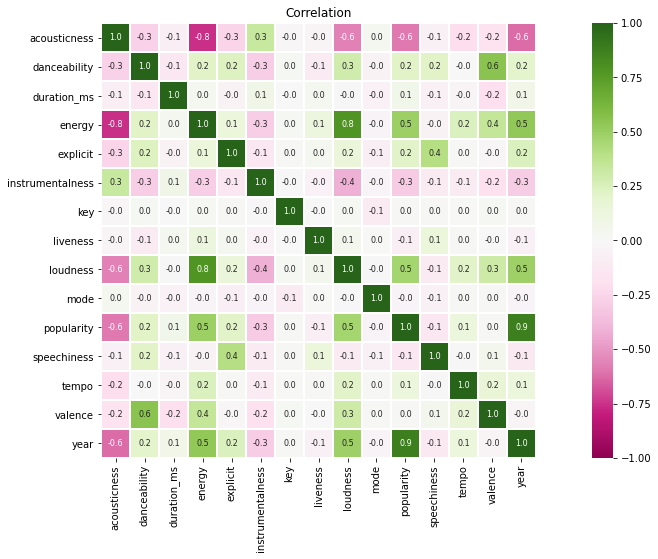

In [4]:
from seaborn import heatmap
corr = data.corr()
plt.figure(figsize=(20,8))
heatmap(corr, vmax=1, vmin=-1, center=0,linewidth=.5,square=True, annot = True, annot_kws = {'size':8},fmt='.1f', cmap='PiYG')
plt.title('Correlation')
plt.show()

WEQRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRDal grafico notiamo che ci sono alcune features che sono scorrelate da tutte le altre. Ci occuperemo di trovare una soglia di correlazione che ci permetterà di escluderle.
così facendo si tolgono: 'duration_ms', 'key', 'liveness', 'mode', 'speechiness', 'tempo'

## **Creation of the Recommender System**

### **How do we take care of clustering?**

To improve our suggestions it's in our interest to **divide** the input data into **clusters**.

We handle this task in this way. At first, for each integer *n* in a prefixed interval, we calculate the *within clusters sum of squares* (wcss) of the data after we dived it in *n* clusters.

Afterwards we choose the **optimal number** of clusters *n* between these candidates. That’s where the *Elbow method* comes into action.


References: https://jtemporal.com/kmeans-and-elbow-method/

In [5]:
def calculate_wcss(data):

  wcss = []

  for n in range(2, 10):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X=data)
    wcss.append(kmeans.inertia_)
    
  return wcss

In [6]:
def optimal_number_of_clusters(wcss):

  x1, y1 = 2, wcss[0]
  x2, y2 = 9, wcss[len(wcss)-1]
  distances = []

  for i in range(len(wcss)):
    x0 = i+2
    y0 = wcss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator/denominator)
    
  return distances.index(max(distances)) + 1

### **Recommender system**

The RecSys Class is the **core** of our **Recommender System**.

It consists of several methods:


*  `clean()` : used to **clean** the initial dataset. We **delete** the features with the **lowest correlation** coefficient.

*  ` user(user_data)`: it takes in **input** a **dictionary** containing the ID values of the songs listended by the user and collects them in a **Pandas Dataframe**.

*  ` cluster()`: splits the user dataframe into several **clusters** by adding a new feature that **labels** the songs.

*  ` get_artists_from_same_genre(artist)`: given an artist in input (**string**), returns a **numpy array** containing similar artists by using the dataframe *data_w_genres*.

*   `suggest(how_many = 20)`: by using the `suggest_cluster` method, returns a **Pandas Dataframe** containing the suggested songs. It can also take as input an **integer** (`how_many`) that controls how many songs are returned.

*   `suggest_cluster(songs, how_many = 20)`: this is the **core method** that handles the suggestion. It operates separately on each cluster. At first it strips the **main dataframe** using `get_artists_from_same_genre` then it assigns a **score** to each song in order to sort them and return the output.








In [7]:
class RecSys():
    
    def __init__(self):

        self.data = pd.read_csv('./data.csv')
        self.data_w_genres = pd.read_csv('./data_w_genres.csv')
        self.clean_data = self.data.copy()
        self.songs = None # will contain the songs from the user data
        self.n = None     # will contain the number of cluster


    def clean(self):
      
        corr = self.clean_data.corr()

        for feature in corr[(abs(corr).sum() - 1) < 1.7].index:  
            del self.clean_data[feature]                           
        
        del self.clean_data['release_date']



    def user(self, user_data):

      items = user_data['tracks']['items']
      id_list = [x['track']['id'] for x in items]
      songs = self.clean_data.copy()
      self.songs = songs.loc[data['id'].isin(id_list)]



    def cluster(self):

      to_cluster = self.songs.copy()

      for x in to_cluster.columns:
        if pd.api.types.infer_dtype(to_cluster[x], skipna=True) not in ['floating','integer']:
          del to_cluster[x]

      wcss = calculate_wcss(to_cluster)
      n = optimal_number_of_clusters(wcss)
      kmeans_model = KMeans(n_clusters= n, max_iter = 600, tol = 0.00001).fit(to_cluster)
      labels = kmeans_model.labels_
      self.songs['cluster'] = labels
      self.n = n



    def get_artists_from_same_genre(self, artist):
      '''
      We look for artists that share the same genre with at least one 
      artist from the user data
      '''
      genres = literal_eval(self.data_w_genres[self.data_w_genres['artists'] == artist]['genres'].to_numpy()[0])
      artists = []

      for genre in genres:
        artists += self.data_w_genres[self.data_w_genres['genres'].str.contains('\'' + genre + '\'')]['artists'].to_list()
      
      if len(artists) == 0:
        return np.array([])
      
      artists = np.unique(artists)
      return artists



    def suggest(self, how_many = 20):
      
        s = pd.DataFrame()

        for i in range(self.n):
           s = s.append(self.suggest_cluster(self.songs[self.songs['cluster'] == i], how_many = how_many // (self.n)))
        
        return s



    def suggest_cluster(self, songs, how_many = 20): 
        
        data_user = songs.copy()

        # We select songs in a interval for the year
        year_mean = data_user['year'].mean()
        interval_start = year_mean - 2*data_user['year'].std()
        interval_end = year_mean + 2*data_user['year'].std()
        
        suggested = self.clean_data.copy()
        suggested = self.clean_data.loc[(self.clean_data['year'] >= interval_start) & (self.clean_data['year'] <= interval_end)]   
        
        # We look for the artists of the same genres of the artists in the user playlist

        similar_artist_list= []
        for list_artist in data_user['artists'].unique():
          for artist_d in literal_eval(list_artist):
            a = self.get_artists_from_same_genre(artist_d)
            if a.size != 0:
              similar_artist_list += a.tolist()
        uni = list( dict.fromkeys( similar_artist_list ) )
        sal = pd.DataFrame([(x, similar_artist_list.count(x)) for x in uni],columns = ['artist', 'count'])
        sal.sort_values(by='count', ascending=False, inplace = True)
        sal = sal['artist'][0:300].to_numpy().tolist()
        suggested = suggested[suggested['artists'].map(lambda x: bool(sum([y in sal for y in literal_eval(x)])))]
        
        # We remove duplicates
        suggested = suggested.drop_duplicates(['id'])
        suggested = suggested.drop_duplicates(['name','artists'])
        
        # We define a score over the song filtered
        # We take as score the euclidean distance from the mean of the user data songs features
        suggested['score'] = abs(suggested['acousticness']**2 - data_user['acousticness'].mean()**2) + \
                             abs(suggested['danceability']**2 - data_user['danceability'].mean()**2) + \
                             abs(suggested['energy']**2 - data_user['energy'].mean()**2) + \
                             abs(suggested['instrumentalness']**2 - data_user['instrumentalness'].mean()**2) +\
                             abs(suggested['loudness']**2 - data_user['loudness'].mean()**2)
        suggested.sort_values(by='score', ascending=True, inplace = True)

        # We delete the songs already present in the user playlist
        suggested = suggested[~(suggested['id'].isin(data_user['id'].values))]
        
        return suggested[0:how_many]

## **Importation of the playlists**

The following cells are **not** part of the **Recommender System** itself: we used this code in order to **import playlists** needed to test our system.

After having loaded the playlists from Spotify, we save them as **json** files in the folder 'playlist'. This procedure allows us to avoid importing the playlist every time we run our system.

We define `get_songs_id(playlist_id, authorization)` to **import** playlists from **Spotify** as **json** files. 

`get_songs_id` requires two input parameters: the **id** of the playlist and an **authorization token** supplied by Spotify.



More information about this procedure can be found at the following link:
[https://developer.spotify.com/documentation/general/guides/authorization-guide/](https://).


```
def get_songs_id(playlist_id, authorization):

  headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': 'Bearer ' + authorization
  }

  params = (
    ('fields', 'tracks.items(track.id)'),
  )

  response = requests.get('https://' + 'api.spotify.com/v1/playlists/' + playlist_id, headers=headers, params=params)
  
  return response.json()

```
The function `merge_playlist(p1, p2)` simply merges two playlists.
It will come in handy to test the recommender system with playlists made of different types of music.

```
def merge_playlist(p1, p2):
  api = p1['tracks']['items'] + p2['tracks']['items']
  return {'tracks':{'items':api}}
```


Once we retrive the authoriztion token we can store it here.

```
authorization = None
```



### **Imported Playlists**

Here are the **playlists** we decided to import from **Spotify**.

#### **Best of AC/DC**

`ACDC = get_songs_id('37i9dQZF1DXec50AjHrNTq',authorization)`

https://open.spotify.com/playlist/37i9dQZF1DXec50AjHrNTq?si=shNIA2iyTHS-aQfjeCBZuQ

*59 tracks*



#### **Hip Hop from the 90s**

`hip_hop_90s = get_songs_id('37i9dQZF1DX186v583rmzp', authorization)`

https://open.spotify.com/playlist/37i9dQZF1DX186v583rmzp?si=JyMSAGWHRfS_Sm9ntCwisw

*100 tracks*


#### **Rock Classics**

`rock = get_songs_id('37i9dQZF1DWXRqgorJj26U', authorization)`

https://open.spotify.com/playlist/37i9dQZF1DWXRqgorJj26U?si=UbyC59oDRNOjFTHkjRQB1g

*145 tracks*


#### **2000s Metal Classics**

`metal = get_songs_id('37i9dQZF1DWXNFSTtym834', authorization)`

https://open.spotify.com/playlist/37i9dQZF1DWXNFSTtym834?si=_UQQRyJRTXy3h12vUacvjw

*139 tracks*

#### **2010s Dance Hits**

`dance_10 = get_songs_id('37i9dQZF1DXaWf8ZIHreXF',authorization)`

https://open.spotify.com/playlist/37i9dQZF1DXaWf8ZIHreXF?si=xQe7FCdaRi2T0pmimlmuew

*99 tracks*


#### **2010s Latino**


`latino_10 = get_songs_id('37i9dQZF1DWZQkHAMKYFuV', authorization)`

https://open.spotify.com/playlist/37i9dQZF1DWZQkHAMKYFuV?si=aIFHfqTwRVuj_lvbLh1_ZA

*84 tracks*


#### **Classical Music**



`classic = get_songs_id('37i9dQZF1DWWEJlAGA9gs0', authorization)`



https://open.spotify.com/playlist/37i9dQZF1DWWEJlAGA9gs0?si=azjfnOkcSDemEvC9r7mtGg

*152 tracks*

#### **Dance + ACDC playlist**

`dance_and_ACDC = merge_playlist(dance_10, ACDC)`


#### **Playlist Rock + Metal**

`rock_and_metal = merge_playlist(ACDC, metal)`


#### **Classic + Latino**

`classic_and_latino = merge_playlist(latino_10, classic)`



#### **Rock + Latino + Classic**

`rock_latino_classic = merge_playlist(classic_and_latino, rock)`



### **Saving playlists in a .json file**

This is the snippet of code we used to save playlists in a json file.
```
with open('dance_and_ACDC.json', 'w') as json_file:
    json.dump(dance_and_ACDC, json_file)
```



### **Loading playlists from the .json file**

Now, we **upload** from the folder 'playlist' the playlists we previously stored. For convenience, we save this playlist in a dictionary named `playlist` where the keys are the names of the playlist and the values are the playlist themselves.

In [8]:
from os import listdir

data_path = './playlist/'
fpaths = []
for f in listdir(data_path):
  fpaths.append(f)

playlist = {}
for p in fpaths:
  with open(data_path + p) as json_file:
    playlist[p.replace('.json','')] = json.load(json_file)

In [9]:
playlist.keys()

dict_keys(['ACDC', 'metal', 'classic_and_latino', 'classic', 'rock', 'rock_latino_classic', 'rock_and_metal', 'rock_90s', 'dance_and_ACDC', 'dance_10', 'latino_10', 'hip_hop_90s'])

## **Testing of our system on real playlists**


In order to retrieve suggestions from users data, we implement the function 
`return_suggest(user_data, how_many)`. This function takes as input the user data, a **Pandas Dataframe**, and the number of suggested songs we want to return.
The function creates a RecSys class object and returns the suggested songs for the user data provided.

In [10]:
def return_suggest(user_data, how_many = 20):
  rs = RecSys()
  rs.clean()
  rs.user(user_data)
  rs.cluster()
  return rs.suggest(how_many)

In [58]:
def std_dev_feature(dataframe):
    result = pd.DataFrame()
    for column in dataframe.columns:
        if pd.api.types.infer_dtype(dataframe[column], skipna=True) == 'floating' or pd.api.types.infer_dtype(dataframe[column], skipna=True) == 'integer':
            result[column]= pd.Series(np.std(dataframe[column]))
    return result

In [59]:
std_dance = std_dev_feature(dance)

In [60]:
std_dance

,acousticness,danceability,energy,explicit,instrumentalness,loudness,popularity,valence,year,score
0,0.068823,0.055553,0.125705,0.447903,0.001199,0.728394,16.833242,0.228811,3.091206,0.100634


### **2010s Dance Hits**

In [11]:
dance = return_suggest(playlist['dance_10'])

In [39]:
np.std(dance['acousticness'])

0.0688234545148529

In [12]:
dance

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
39408,0.12900,"['Minnesota', 'Zion I']",0.655,0.869,0,3KVp3xFBemY9Z4O7vYNfuf,0.000000,-4.348,Float (feat. Zion I),46,0.733,2012,0.123142
40165,0.01190,['Niall Horan'],0.591,0.841,0,0DrFTaAX2srXPkuag35djb,0.000000,-4.351,Nice To Meet Ya,70,0.392,2020,0.151305
23667,0.00857,['Little Mix'],0.697,0.841,0,4z0sS7hwnTZTRKZVahth6J,0.000044,-4.339,Hair,65,0.697,2015,0.164536
55289,0.01570,"['BTS', 'Desiigner', 'Steve Aoki']",0.613,0.842,0,7Ed6BkggCS2KaKY5YlINaF,0.000000,-4.332,MIC Drop (feat. Desiigner) [Steve Aoki Remix],63,0.645,2017,0.195710
40202,0.24300,"['Luis Fonsi', 'Daddy Yankee', 'Justin Bieber']",0.688,0.812,0,19rUsiaEF4kbW0lze5sbjK,0.000000,-4.355,Despacito - Remix,5,0.834,2020,0.210120
15447,0.02810,['Lady Gaga'],0.674,0.715,1,0kS6GezxkbM5YXffQFnID6,0.000000,-4.337,Sexxx Dreams,58,0.381,2013,0.284968
39563,0.02810,['Kid Ink'],0.562,0.682,1,0Altlm3kLPob56k2qqR4i2,0.000045,-5.883,Money and the Power,57,0.385,2014,0.297199
15110,0.00320,['Miley Cyrus'],0.684,0.675,0,3RfNQMIeuL2QC9l4VxOMoj,0.000465,-5.886,Dream,48,0.846,2009,0.327945
97634,0.12100,"['NOTD', 'Felix Jaehn', 'Captain Cuts', 'Georg...",0.700,0.872,0,7FjZU7XFs7P9jHI9Z0yRhK,0.000007,-5.896,So Close,77,0.761,2018,0.340726
116194,0.01510,['Nick Jonas'],0.589,0.611,0,5Eg4TsPcqNbIjd8ADMZosg,0.000000,-5.881,Chains,61,0.121,2015,0.380891


### **Hip Hop from the 90s**

In [13]:
hip_hop = return_suggest(playlist['hip_hop_90s'])

In [14]:
hip_hop

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
133028,0.29600,"['Raekwon', 'Ghostface Killah', 'Nas']",0.814,0.663,1,1kHPOtD1fo3kWOgcs0oisd,0.000003,-7.446,Verbal Intercourse (feat. Ghostface Killah & Nas),44,0.520,1995,0.178136
123752,0.02400,"['Ghostface Killah', 'Raekwon', 'Cappadonna']",0.728,0.723,1,37hqGqe1Btdp6xuljIm4zL,0.000037,-7.441,Fish (feat. Raekwon & Cappadonna),49,0.586,1996,0.229891
14234,0.04320,"['Bone Thugs-N-Harmony', 'Big B']",0.834,0.710,1,1qEzcqwjO4BVS04Y0pfwyM,0.000000,-7.453,Change the World (feat. Big B),42,0.381,2000,0.231274
95929,0.01260,"['Jermaine Dupri', 'Ludacris']",0.751,0.786,1,19VTqucnxJuH6kilNdweTh,0.000000,-7.441,Welcome to Atlanta (feat. Ludacris),56,0.679,2001,0.291359
159349,0.16600,"['JAY-Z', 'Amil', 'Beanie Sigel']",0.771,0.826,1,4EIzsbsVOzfLwyIvfsRQ8H,0.000000,-7.458,Do It Again (Put Ya Hands Up),44,0.338,1999,0.403750
159618,0.25200,"['Charli Baltimore', 'Ja Rule', 'Ashanti', 'Vi...",0.640,0.590,1,21iEEekDSvQjVARSQ4dpXY,0.000000,-7.442,Down 4 U,45,0.519,2002,0.436166
159059,0.31600,['OutKast'],0.742,0.627,1,5aC5KtkmNBfX1iFX4EVfCO,0.000000,-8.921,Decatur Psalm,41,0.586,1996,0.295764
38513,0.09170,['Fugees'],0.607,0.616,0,7oSVxGokmrvwMRdM6rcYsC,0.000016,-8.924,Vocab - Refugees Hip Hop Remix,46,0.550,2003,0.366860
133264,0.11200,['DMX'],0.802,0.671,1,1lnqjCZfobpQe6DXURSvzn,0.000000,-8.909,Bring Your Whole Crew,46,0.284,1998,0.458074
141650,0.00352,['Bone Thugs-N-Harmony'],0.737,0.719,1,3QlZZvDLjdoP5ToIgDQRTE,0.018200,-8.944,Down Foe My Thang,43,0.447,1994,0.462205


### **2000s Metal Classics**

In [15]:
metal = return_suggest(playlist['metal'])

In [16]:
metal

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
61243,0.000391,['Linkin Park'],0.484,0.913,0,7MfJVe7of8qWEMcCwQnAvS,0.000000,-4.305,Pushing Me Away,40,0.279,2000,0.073888
134020,0.000189,['Foo Fighters'],0.462,0.913,0,1QZFn6QUNHfCp8s06C91hw,0.001420,-4.298,DOA,57,0.720,2005,0.084027
46469,0.005590,['Incubus'],0.414,0.873,0,5Ftbraika50jHubFuGkuaW,0.002050,-4.303,Pistola,43,0.435,2004,0.140428
151042,0.000102,['Dry Kill Logic'],0.399,0.937,1,78SOBkauu6CnXV2OtpDrHK,0.000542,-4.311,Rot,50,0.290,2001,0.140749
76094,0.001800,['Slayer'],0.434,0.948,1,6XjkEAl9bPhaV9QtqnmAS4,0.000060,-4.294,Threshold,36,0.317,2001,0.145957
134008,0.000867,['The Offspring'],0.528,0.867,0,4NZn1vRGq9s83B7JWsoQgn,0.000139,-4.298,Gotta Get Away,55,0.607,2005,0.231249
124316,0.002220,['Sum 41'],0.440,0.919,1,3SO0vfryYv381w1ImgWONG,0.005030,-4.462,Over My Head (Better Off Dead),48,0.773,2002,0.119626
53615,0.000018,['Spineshank'],0.480,0.925,0,2xV28mhkI7AzwpJEqPGSb3,0.000009,-4.449,Synthetic,40,0.460,2000,0.122064
14610,0.000099,['Breaking Benjamin'],0.462,0.871,1,2lpcY0lROi0khLsnBCMp1W,0.000000,-4.448,Simple Design,43,0.509,2004,0.124643
38650,0.004410,['Theory of a Deadman'],0.395,0.893,0,06hNjTThF575UgFeWq2VTZ,0.000000,-4.450,Say Goodbye,42,0.436,2005,0.125446


### **Best of AC/DC**

In [17]:
ACDC = return_suggest(playlist['ACDC'])

In [18]:
ACDC

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
43840,0.144000,['Van Halen'],0.457,0.932,0,5TBtYY6MvppYOpDBsQwzi6,0.000092,-4.988,Runnin' with the Devil - 45 Version,22,0.473,1978,0.252063
157821,0.040700,['Red Hot Chili Peppers'],0.641,0.899,0,3feCEAjM17x1fdQLmpbv98,0.000001,-4.992,True Men Don't Kill Coyotes - 2002 Digital Rem...,38,0.562,1984,0.305570
158035,0.021000,['Ozzy Osbourne'],0.516,0.966,0,45faLsegmASiOQneczF4C5,0.001820,-4.972,Thank God for the Bomb,35,0.557,1986,0.371089
139946,0.006320,['Sex Pistols'],0.343,0.962,0,2Hs7YqZwFEPIxRTnqtrHvP,0.000059,-4.984,Liar,33,0.312,1977,0.391999
28915,0.005550,['Red Hot Chili Peppers'],0.578,0.957,0,3cWEHEBIJzikXa9xPzMQkC,0.000294,-5.000,Backwoods,35,0.468,1987,0.417983
112769,0.007670,['Ramones'],0.334,0.925,0,47tVRotmsKNeNqO7xU5og2,0.000003,-4.973,You Sound Like You're Sick - 2002 Remaster,45,0.756,1981,0.437781
122282,0.008000,['Rick Springfield'],0.454,0.891,0,0q9kwsDddMpLd5PVctArlK,0.000003,-4.851,Love Is Alright Tonite,35,0.800,1981,0.214087
59744,0.176000,['R.E.M.'],0.515,0.809,0,2q5WqgivCVnCxKXVbNzWs0,0.012400,-4.864,Green Grow The Rushes - Remastered,25,0.537,1985,0.248695
36433,0.000937,['Tom Petty and the Heartbreakers'],0.484,0.906,0,1BbMhfUaNtdpwoHaCuPVhC,0.000503,-4.857,A One Story Town,25,0.827,1982,0.271212
28767,0.032300,['Peter Gabriel'],0.584,0.921,0,36a311Jq8qByai9eCwpzo1,0.000001,-4.850,Solsbury Hill - Live,24,0.435,1986,0.282502


### **Rock Classics**

In [19]:
rock = return_suggest(playlist['rock'])

In [64]:
rs = RecSys()
rs.clean()
rs.user(playlist['rock'])
rs.cluster()


In [68]:
rs.songs.head(30)

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,cluster
82442,0.038300,['The Rolling Stones'],0.723,0.863,0,2PzU4IB8Dr6mxV3lHuaG34,0.031700,-7.890,(I Can't Get No) Satisfaction - Mono Version,76,0.931,1965,1
82446,0.729000,['Bob Dylan'],0.483,0.721,0,3AhXZa8sUQht0UEdBJgpGc,0.000000,-6.836,Like a Rolling Stone,72,0.562,1965,1
82449,0.135000,['The Byrds'],0.452,0.818,0,5qBqBdfTEIWJwAS0Jm2F5R,0.000027,-8.124,Turn! Turn! Turn! (To Everything There Is a Se...,68,0.755,1965,2
82540,0.406000,['Buffalo Springfield'],0.653,0.519,0,1qRA5BS78u3gME0loMl9AA,0.020900,-10.164,For What It's Worth,75,0.822,1966,1
82553,0.000825,['The Animals'],0.315,0.534,0,61Q9oJNd9hJQFhSDh6Qlap,0.108000,-7.552,House Of The Rising Sun,60,0.283,1966,2
82580,0.010300,['The Rolling Stones'],0.505,0.836,0,1RJeiAIwR9pZBgJA8ndZLL,0.077100,-7.384,"Paint It, Black - Mono",65,0.764,1966,2
82653,0.369000,['The Doors'],0.413,0.725,0,5uvosCdMlFdTXhoazkTI5R,0.000022,-5.787,Light My Fire,72,0.440,1967,1
82654,0.408000,['Jefferson Airplane'],0.504,0.578,0,4uGIJG1jYFonGc4LGp5uQL,0.000000,-9.302,Somebody to Love,70,0.654,1967,2
82741,0.002550,['Jimi Hendrix'],0.438,0.805,0,2aoo2jlRnM3A0NyLQqMN2f,0.000057,-6.237,All Along the Watchtower,77,0.564,1968,1
82841,0.201000,['Creedence Clearwater Revival'],0.640,0.663,0,4BP3uh0hFLFRb5cjsgLqDh,0.008060,-7.516,Fortunate Son,80,0.663,1969,1


In [61]:
std_dev_feature(rock)

,acousticness,danceability,energy,explicit,instrumentalness,loudness,popularity,valence,year,score
0,0.121835,0.108989,0.127684,0.0,0.085218,1.610476,11.194977,0.218198,7.143354,0.117939


In [20]:
rock

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
102808,0.3440,['Rush'],0.414,0.737,0,2fsFnXtYfu3xkz9QXj1pZs,0.001720,-8.662,Bastille Day,44,0.750,1975,0.250522
11492,0.3010,['George Harrison'],0.485,0.800,0,3XLeGkYI3ekR5ByhrNauEN,0.000289,-8.663,Bangla Desh - Bonus Track,34,0.569,1973,0.273117
83730,0.2590,['Paul Davis'],0.534,0.457,0,08kvJTpcthAvvvW0BAcGHN,0.000400,-8.660,I Go Crazy,56,0.271,1977,0.323368
148273,0.1790,['The Beatles'],0.502,0.685,0,3OtsmzTZs50ahEnHKVvozC,0.000006,-8.679,Paperback Writer - Remastered 2009,40,0.805,1973,0.377165
155910,0.2660,['The Beach Boys'],0.570,0.729,0,5tMdozSo7PxEauLDeegHEg,0.000037,-8.646,Then I Kissed Her (Stereo),31,0.860,1965,0.383348
20532,0.3420,['U2'],0.606,0.790,0,7KIx7fLrEWT6TCOc58iqAq,0.000041,-9.144,Seconds - Remastered 2008,30,0.973,1983,0.219645
114096,0.0798,['Pearl Jam'],0.633,0.543,0,5TxUedy2CM04QihDdOFnsk,0.006710,-9.142,Immortality - Remastered,56,0.118,1994,0.329685
93828,0.0507,['The Police'],0.811,0.767,0,7A4rW6quroPut2I6OsCys9,0.013800,-9.140,Canary In A Coalmine,50,0.964,1980,0.390499
131157,0.0204,['David Bowie'],0.510,0.731,0,73HwMEPCCCEqKFYONpOxe9,0.393000,-9.142,Always Crashing in the Same Car - 2017 Remaster,43,0.486,1977,0.391118
5197,0.1930,['Toad The Wet Sprocket'],0.587,0.671,0,1Cm7r3vn8AdY9ZUXgsTtKS,0.000000,-9.129,Nightingale Song,34,0.843,1991,0.407801


### **2010s Latino**

In [21]:
latino_10 = return_suggest(playlist['latino_10'])

In [22]:
latino_10

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
106123,0.00758,['Arcangel'],0.897,0.755,0,1pLCpA1RN8avJxSD3ZCwhj,0.000451,-5.684,Pa' Que La Pases Bien,65,0.5670,2008,0.300071
54630,0.19800,"['Wisin & Yandel', 'Cosculluela', 'Tego Calder...",0.845,0.845,0,6LgGKcMoXvDtKgAp2znkKQ,0.000001,-5.674,La Reunión De Los Vaqueros,53,0.6620,2010,0.383680
62032,0.27500,"['Héctor ""El Father""']",0.802,0.873,0,5QpUAyROQsLtNLPY5TJcFv,0.000003,-5.698,Tu Quieres Duro,48,0.0933,2008,0.461340
168863,0.26000,['Intocable'],0.614,0.834,0,1iEu0w8EG4xkNpmzzy4SyP,0.000000,-5.705,Eres Mi Droga,58,0.9620,2010,0.577972
15386,0.23400,['Cali Y El Dandee'],0.481,0.810,0,0mGvaKpwLYoybnIoboC3uS,0.000000,-5.704,Yo Te Esperaré,69,0.3280,2012,0.659898
144271,0.03250,['Myke Towers'],0.733,0.708,1,43NqTeL8pgBxKHPMiJKUP5,0.000327,-4.957,Girl,80,0.6940,2020,0.180416
97829,0.32100,"['Bad Bunny', 'Nicky Jam']",0.590,0.729,1,5bmSver2b3ZXyuyLKtgnFI,0.000000,-4.950,BAD CON NICKY,85,0.7120,2020,0.210284
23819,0.13400,['Sebastian Yatra'],0.776,0.684,0,79Jhw5xn4gGn6PZak275gg,0.000000,-4.950,Traicionera,65,0.6580,2016,0.225923
152677,0.05610,"['Nicky Jam', 'J Balvin', 'Maluma', 'Ozuna']",0.663,0.696,0,6JjPBQfI2Y8nIjnm65X6Pw,0.000038,-4.957,X (feat. Maluma & Ozuna) - Remix,71,0.7380,2018,0.239188
77514,0.22100,"['Zion & Lennox', 'Farruko', 'Yandel']",0.716,0.795,0,7dnOGJWp5Mspq4drP0oaxZ,0.000000,-4.930,Pierdo la Cabeza - Remix,61,0.6660,2015,0.371060


### **Classical Music**


In [23]:
classic = return_suggest(playlist['classic'])

In [24]:
classic

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
53823,0.995,"['Erik Satie', 'Jean-Yves Thibaudet']",0.3710,0.00246,0,5SZ47jchNPq4i4dhpcNPdA,0.9630,-31.159,Gnossiennes: No. 1 - Lent,46,0.1630,2002,1.886881
54522,0.995,"['Johann Sebastian Bach', 'Anne Queffélec']",0.2980,0.03570,0,0p6eXDSAFhKm9CB192DLeB,0.8640,-31.271,"Choral ""Jesu, meine Freude"" de la Cantate ""Her...",52,0.4250,2009,5.962336
39359,0.924,"['Camille Saint-Saëns', 'Royal Scottish Nation...",0.2910,0.01560,0,4TZzzWTrTyW8F4FoFFKvec,0.0876,-31.355,"Le rouet d'Omphale, Op. 31",50,0.0566,2012,11.546975
151615,0.996,"['Philip Glass', 'Bruce Brubaker']",0.1790,0.02600,0,1QmhkjuUlosROqKk59sBSK,0.8900,-30.937,Opening,56,0.0680,2007,15.466819
160000,0.995,"['Edvard Grieg', 'Shani Diluka']",0.4070,0.00453,0,6G6tIDO3rB8FktjkM70GGd,0.9350,-30.925,"Pièces Lyriques, Op. 47 No. 3: Mélodie",54,0.0342,2006,16.389387
159355,0.903,"['Johannes Brahms', 'Budapest Festival Orchest...",0.3490,0.05030,0,2cFsO1qC65joLn2GzRViBI,0.1530,-18.668,"Hungarian Dance No.5 in G Minor, WoO 1, No.5",45,0.2950,1999,0.633725
75892,0.413,"['Richard Strauss', 'London Philharmonic Orche...",0.1570,0.17500,0,41kd6nWfxAytm08XVujL7q,0.8560,-18.829,Also Sprach Zarathustra Op.30: Einleitung (Ope...,46,0.0348,1999,7.176030
54164,0.925,"['John Williams', 'London Symphony Orchestra']",0.0604,0.14700,0,2Tlv01jTgfA79TGMFrJx1O,0.7830,-18.954,The Birth of the Twins and Padmé's Destiny,44,0.0364,2005,11.211430
69165,0.857,"['John Williams', 'London Symphony Orchestra']",0.1200,0.13300,0,00sPWXrRQtyGn9BqoPbMCd,0.8670,-18.955,Grievous Speaks to Lord Sidious,43,0.0616,2005,11.399995
142453,0.984,"['Dmitri Shostakovich', 'Russian State Symphon...",0.3220,0.18400,0,0pjCsB0XNSyqM9UazlTODC,0.9020,-18.312,Jazz Suite No. 2: VI. Waltz 2,57,0.3560,2002,13.591146


### **2010 Dance Hits and Best of AC/DC**

In [25]:
dance_and_ACDC = return_suggest(playlist['dance_and_ACDC'])

In [26]:
dance_and_ACDC

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
116110,0.000629,['Tiësto'],0.654,0.830,0,5L2l7mI8J1USMzhsmdjat9,0.000001,-4.801,Red Lights,68,0.548,2014,0.125906
8124,0.356000,"['Kygo', 'Joe Janiak']",0.630,0.826,0,4gGIqmBDfECUFBOSYOoW3a,0.000007,-4.798,Follow,69,0.239,2020,0.190223
152205,0.002470,['Avicii'],0.586,0.727,0,1CKtxKqyFsFITCH4SpDrWj,0.010700,-4.799,You Make Me,66,0.496,2013,0.205700
87477,0.021500,['Flo Rida'],0.688,0.702,0,6Knv6wdA0luoMUuuoYi2i1,0.000000,-4.792,My House,76,0.740,2015,0.260670
40094,0.328000,['Chris Brown'],0.605,0.752,1,6ZOXF7nbzCpPVNlC0AG1rF,0.000000,-4.791,Indigo,66,0.526,2019,0.263848
77005,0.036000,['Nelly Furtado'],0.720,0.777,0,2NwuwbqiCJqnxC4yKh0Fqp,0.000286,-4.808,Maneater,42,0.728,2010,0.271662
59744,0.176000,['R.E.M.'],0.515,0.809,0,2q5WqgivCVnCxKXVbNzWs0,0.012400,-4.864,Green Grow The Rushes - Remastered,25,0.537,1985,0.289266
4803,0.040100,['R.E.M.'],0.689,0.826,0,7GEQic2y8KjVONDyRvZgCK,0.000000,-4.877,Exhuming McCarthy - Remastered,38,0.967,1987,0.312405
103882,0.071100,['R.E.M.'],0.432,0.852,0,3xPKSMgZl4N3rfTyIgSPfa,0.000391,-4.865,Fall On Me - 2011 Remaster,48,0.596,1986,0.327917
113383,0.000108,['The Smiths'],0.406,0.926,0,38ZW90yqTca2NYmh3uy4xV,0.013600,-4.875,Girl Afraid - 2011 Remaster,49,0.911,1987,0.383752


### **Classical and Latino**

In [27]:
ch = return_suggest(playlist['classic_and_latino'])

In [28]:
ch

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
20594,0.9860,"['Wolfgang Amadeus Mozart', 'Sir Neville Marri...",0.0936,0.0515,0,0DjF3du8ElXf88t29pLifV,0.896000,-20.596,"Requiem, K. 626. Lacrymosa",25,0.0337,1984,0.666841
148573,0.9730,"['Jules Massenet', 'James Galway', 'David Meas...",0.2040,0.1620,0,76EQ0fFYsGKyVl0qANQXXb,0.942000,-20.579,Méditation,39,0.0433,1976,1.372455
142561,0.9720,"['Franz Liszt', 'YUNDI']",0.2960,0.2320,0,7x7WWeEqIKIPPRCmcYexeV,0.785000,-20.553,"Grandes études de Paganini, S141: No.3 In G Sh...",51,0.3930,2003,2.218387
74952,0.8770,"['Johann Sebastian Bach', 'Elizabeth Wallfisch...",0.5580,0.1880,0,2hTOFrOwoYfpeQeKjvl1z3,0.000106,-20.559,"Bach, J.S.: Brandenburg Concerto No. 5 in D Ma...",31,0.6850,1989,2.386081
166070,0.9920,"['Nikolaus Harnoncourt', 'Rachel Yakar']",0.1350,0.0934,0,25NKS4Vv5pIxfBPye964QD,0.731000,-20.649,"Mozart: Requiem in D Minor, K. 626: I. Requiem...",37,0.0615,1982,2.391695
149286,0.9770,"['Johann Sebastian Bach', 'Yo-Yo Ma']",0.3390,0.2130,0,5A00HKycJpzTqjo8f9RzkR,0.908000,-20.642,"Cello Suite No. 2 in D Minor, BWV 1008: VI. Gigue",31,0.7590,1983,2.393753
8145,0.0587,"['Anuel AA', 'Tego Calderon']",0.7130,0.7700,1,2WzUy86kPLYRLRwLtinZ1x,0.000501,-4.779,Rifles Rusos,71,0.6840,2020,0.207035
134629,0.2310,"['Alexis y Fido', 'Franco ""El Gorilla""']",0.7110,0.8410,0,3tI4duDhHmmz1Sp7RX0Jbq,0.000098,-4.775,Mala Conducta (feat. Franco El Gorila),63,0.9640,2011,0.289628
126101,0.1980,"['Luis Fonsi', 'Daddy Yankee']",0.6550,0.7970,0,6habFhsOp2NvshLv26DqMb,0.000000,-4.787,Despacito,79,0.8390,2019,0.369458
116671,0.0411,"['Rvssian', 'Anuel AA', 'Juice WRLD']",0.6800,0.7660,0,2AuWgceaQyfMoI3EGavwGb,0.000000,-4.799,No Me Ame,78,0.2800,2020,0.440177


### **Rock, Latino and Classical**

In [29]:
rlc = return_suggest(playlist['rock_latino_classic'])

In [30]:
rlc

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,loudness,name,popularity,valence,year,score
19627,0.4500,['Bad Company'],0.531,0.588,0,4LRiNOcB9fWg0SwhCPf5yB,0.005160,-9.493,"Little Miss Fortune - B-Side of ""Can't Get Eno...",25,0.7050,1974,0.254275
2841,0.3520,['The Beatles'],0.597,0.660,0,33M8Tg2vvZYsmJIuGa3zZd,0.009130,-9.499,Sgt. Pepper's Lonely Hearts Club Band - Take 9...,29,0.5560,1967,0.264398
164155,0.2320,['The Beach Boys'],0.608,0.606,0,3N2HzHr1mCOJj6DzdLdX30,0.000004,-9.484,South Bay Surfer (Mono),19,0.9670,1963,0.333195
148284,0.3310,['The Who'],0.469,0.494,0,75AhlGB9aFWTxDfbmbdiCH,0.000000,-9.495,Cut My Hair,31,0.4080,1973,0.363047
139973,0.0185,['10cc'],0.737,0.642,0,1fMGRxKRtIKNyaMMGrzInM,0.004150,-9.492,Good Morning Judge,45,0.4670,1977,0.363429
28059,0.1710,['David Bowie'],0.523,0.495,0,7GUqTaobt7S0eQp6QXE4dE,0.000003,-9.499,Yassassin - Turkish For: Long Live; 2017 Remaster,33,0.7460,1979,0.376012
111161,0.2950,['The Byrds'],0.496,0.701,0,46uLYXCBGVCkAFLV6YH2PQ,0.000111,-9.506,It Won't Be Wrong,34,0.8600,1965,0.377214
44034,0.2770,['Steve Winwood'],0.709,0.515,0,4cb4G2AmsubdfoqdD4p0TF,0.000193,-9.493,Slowdown Sundown,27,0.5690,1980,0.420001
102156,0.0722,['The Beatles'],0.587,0.431,0,2ck8lFrYAch2GPtdhpTHe3,0.000000,-9.495,All Together Now - Remastered 2009,47,0.7780,1969,0.427736
65473,0.1900,['The Who'],0.383,0.744,0,2JfJkTJOOBP5ZF7dp3XFr3,0.000355,-9.484,Overture - Live / Including Introduction,23,0.1690,1969,0.447338
